# Introducción

En el siguiente documento se procede al análisis y preprocesamiento de las imágenes del dataset del White Matter Hyperintensity Segmentation Challenge[1]. El dataset contiene un conjunto de datos de resonancia magnética del cerebro con diversas lesiones de materia blanca. Se obtuvo a través del repositorio oficial del concurso.

# Carga de paquetes

A continuación se muestran los paquetes y librerías empelados para hacer esta tarea.

In [1]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import random
from tqdm import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt


import pylab as pl
from IPython import display


import nibabel as nib

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datos

El dataset contiene una serie de directorios: [pág. 7 readme.pdf]

- training: Contiene los datos de entrenamiento. Los datos se dividen en tres carpetas, Amsterdam, Utrecht, Singapore ya que los datos provienen de diferentes hospitales de Amsterdam y Singapur. 
- test: Contiene los datos de test. También sigue la estructura del directorio training- 
- additional_annotations: Contiene anotaciones manuales adicionales de los datos. 

En el dataset, para cada una de las resonancias, has dos directorios y la segmentación manual de la resonancia. El primer directorio orig contiene las imágenes originales y el directorio pre contiene las imágenes preprocesadas con el software [SPM12 r6685](http://www.fil.ion.ucl.ac.uk/spm/software/spm12/). Este software se emplea para el análisis de imágenes funcionales de cerebros y su procesamiento. 

En nuestro dataset existen tres tipos de resonancias: 

- FLAIR: Nos permite observar ciertos problemas del cerebro al reducir la señal del líquido cefalorraquídeo. Ayuda a encontrar enfermedades que afectan el cerebro. El líquido aparece brillante lo que indica problemas médicos ( tumores, inflamación o problemas de flujo sanguíneo). También, puede que aparezca brillante por problemas técnicos al tomar la imagen. [2]

- T1: Estas resonancias muestran partes brillantes que representan los tejidos que con protones que no se mueven mucho. Mientras, el líquido cefalorraquídeo aparece más oscuros.[3] Más adelante podremos observar que las manchas en esta resonancia se ven oscuras. 

- 3DT1: No serán empleadas al no ir alienadas con la máscara proporcionada. 

- T2: Estas resonancias muestran diferentes problemas como sangrado, hinchazón, tumores o tejido muerto. Las zonas que aparecen brillantes son aquellas donde los protones se mueven. El líquido cefalorraquídeo se verá brillante. [3]

Además, las imágenes tienen el formato .nii.gz. Este formato indica que se trata de una neuroimagen [NIFTI](https://nifti.nimh.nih.gov/). Por ello, vamos a emplear la librería nibabel para poder leer los archivos y mostrarlos.  Para [instalar la librería](https://pypi.org/project/nibabel/) se debe ejecutar el siguiente comando en el entorno de conda que se emplee: 

In [415]:
#pip install nibabel

Emplearemos la función load(), indicando el path a la imagen para poder cargar el fichero.

## Carga de Datos

A continuación, vamos a cargar los datos proporcionadoos en un diccionario. En primer lugar, guardamos las direcciones a los directorios de datos en diferentes constantes. Tenemos una constante con la dirección a la carpeta datos, posteriormente para cada lugar(Amsterdam, Singapore y Utrecht) se crea una constante para su directorio de train y test.

In [2]:
BASE_PATH = os.getcwd() + "\\data"
TRAINING_PATH_AMSTERDAM= BASE_PATH + "\\training\\Amsterdam\\GE3T\\"
TRAINING_PATH_SINGAPORE= BASE_PATH + "\\training\\Singapore\\"
TRAINING_PATH_UTRECHT= BASE_PATH + "\\training\\Utrecht\\"

TEST_PATH_AMSTERDAM= BASE_PATH + "\\test\\Amsterdam\\"
TEST_PATH_SINGAPORE= BASE_PATH + "\\test\\Singapore\\"
TEST_PATH_UTRECHT= BASE_PATH + "\\test\\Utrecht\\"

Creamos la siguiente función "createDictionary", tiene como parámetros un string con el path al directorio y un diccionario donde se almacenan los datos. 

Se cargaran los paths de las resonancias preprocesadas del directorio pre. 

Por cada directorio se listan los subdirectorios que contienen las resonancias FLAIR, T1 y la máscara marcada manualmente y se añaden cada uno al diccionario en la key correspondiente:

In [3]:
def createDictionary(path:str, DICT: dict,location:str):
    subdirectories= os.listdir(path)
    for x in subdirectories:
        DICT["mask"].append(os.path.join(path,x, "wmh.nii.gz"))
        DICT["pathsT1"].append(os.path.join(path,x, "pre", "T1.nii.gz"))
        DICT["pathsFLAIR"].append(os.path.join(path,x, "pre", "FLAIR.nii.gz"))
        DICT["location"].append(location)

Creamos el diccionario de training inicialmente vacío que almacenará los paths a las resonancias FLAIR, T1 y las máscaras. Comprobamos que se han almacenado correctamente los datos y la cantidad de imágenes que contiene el training: 

In [4]:
TRAINING_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[]
}
createDictionary(TRAINING_PATH_UTRECHT, TRAINING_DICT,"Utrecht")
createDictionary(TRAINING_PATH_SINGAPORE, TRAINING_DICT, "Singapore")
createDictionary(TRAINING_PATH_AMSTERDAM, TRAINING_DICT,"Amsterdam")
print(TRAINING_DICT.get("pathsFLAIR").__getitem__(0))
print(TRAINING_DICT.get("pathsT1").__getitem__(0))

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\data\training\Utrecht\0\pre\FLAIR.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\data\training\Utrecht\0\pre\T1.nii.gz


In [5]:
TEST_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[]
}
createDictionary(TEST_PATH_UTRECHT, TEST_DICT,"Utrecht")
createDictionary(TEST_PATH_SINGAPORE, TEST_DICT,"Singapore")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE1T5"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE3T"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "Philips_VU .PETMR_01"), TEST_DICT,"Amsterdam")
print(TEST_DICT.get("pathsFLAIR").__getitem__(0))
print(TEST_DICT.get("pathsT1").__getitem__(0))


c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\data\test\Utrecht\1\pre\FLAIR.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\data\test\Utrecht\1\pre\T1.nii.gz


Vamos a observar cuántas imágenes hay de cada tipo en cada uno de los conjuntos: 

In [6]:
print("total training FLAIR images", len(TRAINING_DICT.__getitem__("pathsFLAIR")))
print("total test FLAIR images", len(TEST_DICT.__getitem__("pathsFLAIR")))

print("total training T1 images", len(TRAINING_DICT.__getitem__("pathsT1")))
print("total test T1 images", len(TEST_DICT.__getitem__("pathsT1")))

total training FLAIR images 60
total test FLAIR images 110
total training T1 images 60
total test T1 images 110


Como podemos observar tenemos un desbalance de datos. Lo usual es que haya más datos de entrenamiento que de test. En nuestro caso podemos observar que sucede lo contrario. Este desbalance es de casi el doble de datos. También, es un dataset bastante pequeño, ya que consta de 120 imágenes para training y de 220 para test.

Esto nos indica que posiblemente deberemos añadir más imágenes en el entrenamiento. O bien adquiridas a través de otros datasets o bien mediante la aplicación de efectos ( data augmentation)

## Visualización de los datos

A continuación vamos a observar como son las imágenes proporcionadas:

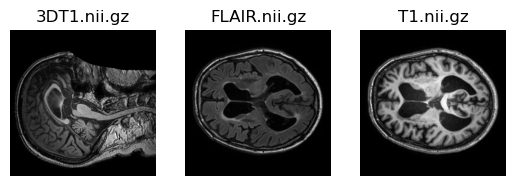

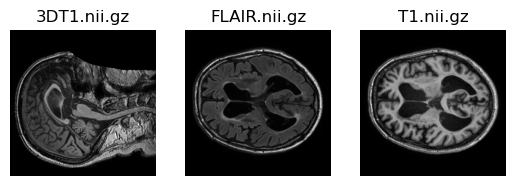

In [7]:
pre_files = os.listdir(os.path.join(TRAINING_PATH_UTRECHT, "0", "pre"))
orig_files = os.listdir(os.path.join(TRAINING_PATH_UTRECHT, "0", "orig"))


fig,axs = plt.subplots(1, 3)
x=0
for i in (pre_files):
    img = nib.load(os.path.join(TRAINING_PATH_UTRECHT, "0", "orig", i))
    image_data = img.get_fdata() 
    axs[x].imshow(image_data[:, :, image_data.shape[2] // 2], cmap='gray')
    axs[x].set_title(i)
    axs[x].axis('off')
    x+= 1
plt.show()


fig,axs = plt.subplots(1, 3)
x=0
for i in (pre_files):
    img = nib.load(os.path.join(TRAINING_PATH_UTRECHT, "0", "pre", i))
    image_data = img.get_fdata() 
    axs[x].imshow(image_data[:, :, image_data.shape[2] // 2], cmap='gray')
    axs[x].set_title(i)
    axs[x].axis('off')
    x+= 1
plt.show()



Las tres resonanciass de arriba provienen de la carpeta orig. Como podemos observar, la resonancias T1 posee mucha luminosidad a diferencia del resto. En la segunda fila, aparecen las resonanciass con el procesameiento aplicado. Podemos observar que la imagen T1 ha disminuido su luminosidad y el color parece más uniforme. 

Vamos a observar la máscara:

(240, 240, 48)


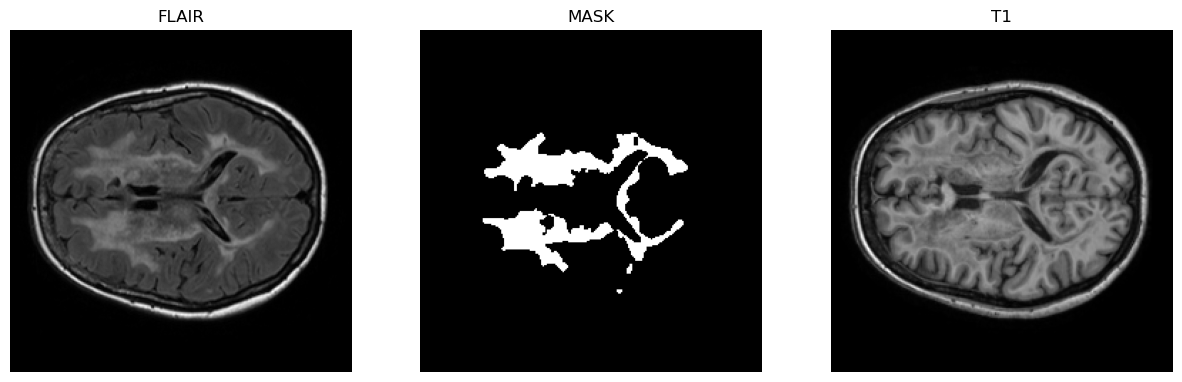

In [10]:
fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TEST_PATH_UTRECHT, "9","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print(image_data.shape)
axs[0].imshow(image_data[:, :, image_data.shape[2] // 2], cmap='gray')
axs[0].set_title("FLAIR")
axs[0].axis('off')

mask= os.path.join(TEST_PATH_UTRECHT, "9", "wmh.nii.gz")
img = nib.load(mask)
image_data = img.get_fdata() 
merged_image= np.array(image_data)
merged_image[merged_image==1]=255
merged_image[merged_image==2]=0
merged_image[merged_image==3]=255
image_data= merged_image


axs[1].imshow(image_data[:, :, image_data.shape[2] // 2], cmap='gray')
axs[1].set_title("MASK")
axs[1].axis('off')

t1= os.path.join(TEST_PATH_UTRECHT, "9","pre","T1.nii.gz")
img = nib.load(t1)
image_data = img.get_fdata() 
axs[2].imshow(image_data[:, :, image_data.shape[2] // 2], cmap='gray')
axs[2].set_title("T1")
axs[2].axis('off')

plt.show()

Como podemos observar las manchas son más visibles en FLAIR que en T1. 
La máscara tiene tres etiquetas: 
- 0: es el fondo.
- 1: son la materia blanca 
- 2: Otras patologías.

Nuestro objetivo es obtener la segmentación de la materia blanca. 

## Características de las imágenes

A continuación vamos a observar algunas características de las imágenes.

### Forma

In [16]:
flair= os.path.join(TRAINING_PATH_UTRECHT, "0","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print("FLAIR UTRECHT",image_data.shape)
flair= os.path.join(TRAINING_PATH_UTRECHT, "0","pre","T1.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print("T1 UTRECHT",image_data.shape)
flair= os.path.join(TRAINING_PATH_SINGAPORE, "50","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print("FLAIR SINGAPORE",image_data.shape)
flair= os.path.join(TRAINING_PATH_SINGAPORE, "50","pre","T1.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print("T1 SINGAPORE",image_data.shape)
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print("FLAIR AMSTERDAM GE3T",image_data.shape)
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print("T1 AMSTERDAM GE3T",image_data.shape)
flair= os.path.join(TEST_PATH_AMSTERDAM,"GE1T5","150","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print("FLAIR AMSTERDAM GE1T5",image_data.shape)
flair= os.path.join(TEST_PATH_AMSTERDAM,"Philips_VU .PETMR_01","160","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
print("FLAIR AMSTERDAM Philips_VU .PETMR_01",image_data.shape)

FLAIR UTRECHT (240, 240, 48)
T1 UTRECHT (240, 240, 48)
FLAIR SINGAPORE (256, 232, 48)
T1 SINGAPORE (256, 232, 48)
FLAIR AMSTERDAM GE3T (132, 256, 83)
T1 AMSTERDAM GE3T (132, 256, 83)


FLAIR AMSTERDAM GE1T5 (128, 256, 103)
FLAIR AMSTERDAM Philips_VU .PETMR_01 (321, 240, 83)


### Tamaño

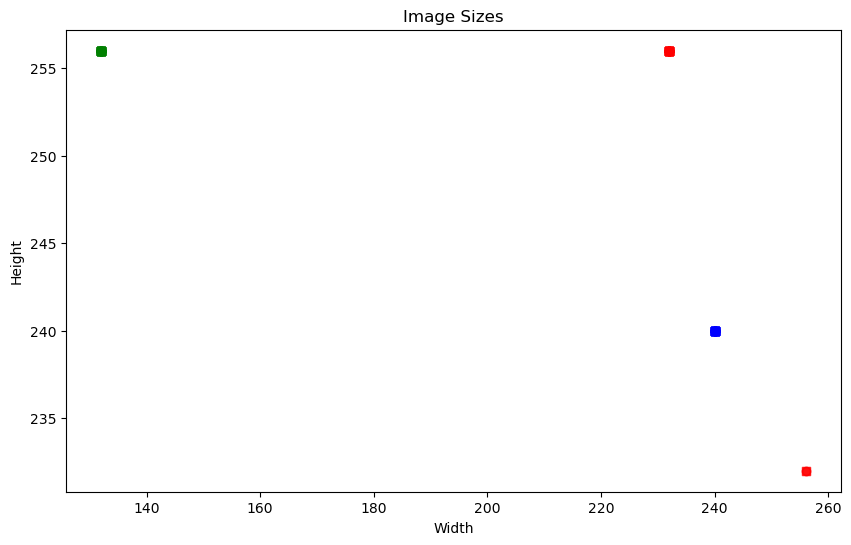

In [8]:
image_sizes = []
#Blue if Utrecht, Red if Singapore, Green if Amsterdam
c_labels=["blue", "red", 'green']
# Circle if FLAIR, square if T1
m_labels=['o','s']
labels=[]
markers=[]
for flair, t1, location in zip(TRAINING_DICT.get('pathsFLAIR'),TRAINING_DICT.get('pathsT1'), TRAINING_DICT.get("location")):
        img = nib.load(flair)
        image_data = img.get_fdata() 
        width, height, depth  = image_data.shape
        image_sizes.append((width,height))
        markers.append(m_labels[0])
        labels.append(c_labels[["Utrecht", "Singapore", "Amsterdam"].index(location)])
      

        img2 = nib.load(t1)
        image_data2 = img2.get_fdata() 
        width, height, depth  = image_data2.shape
        image_sizes.append((width, height))
        markers.append(m_labels[1])
        labels.append(c_labels[["Utrecht", "Singapore", "Amsterdam"].index(location)])

# Esto separa el ancho y el alto: 
widths, heights = zip(*image_sizes)

plt.figure(figsize=(10, 6))
for i, (width, height) in enumerate(zip(widths,heights)):
        plt.scatter(width, height, c=labels[i],marker=markers[i], alpha=0.5)
plt.title('Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


Como podemos observar solo hay cuatro tamaños predeterminados de imagen. Siendo las resonanciass de Amsterdam las más altas y menos anchas, las de Singapur tienen dos tamaños de imagen y las de Utrecht poseen el mismo ancho y alto. 

En el siguiente gráfico se pueden observar para cada lugar, el número exacto de imágenes que hay según el tamaño:

{((240, 240), 'blue'): 40, ((256, 232), 'red'): 4, ((232, 256), 'red'): 36, ((132, 256), 'green'): 40}


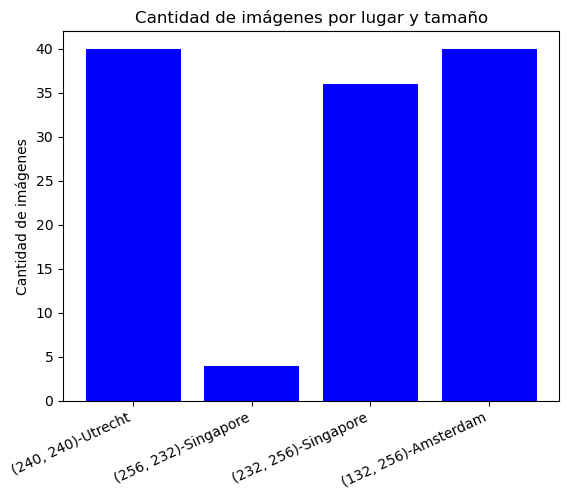

In [74]:
size_location_counts = {}
locations=["Utrecht","Singapore","Singapore","Amsterdam"]
for size,label in zip(image_sizes, labels):
    if (size,label) not in size_location_counts:
        size_location_counts[(size,label)] = 0
    size_location_counts[(size,label)] += 1
    
print(size_location_counts)

plt.bar(["Utrecht","Singapore","Singapore2","Amsterdam"], list(size_location_counts.values()), color='blue')
plt.ylabel('Cantidad de imágenes')
plt.title('Cantidad de imágenes por lugar y tamaño')
plt.xticks(range(len(size_location_counts.keys())), [f"{size}-{label}" for(size,_),label in zip(size_location_counts,locations)], rotation=25, ha='right')
plt.show()

Las de Amsterdam y Utrecht tienen el mismo número de imágenes(40), mientras que Singapur tiene cuatro imágenes cuyo tamaño es diferente. Si observamos el tamaño podemo ver que la imagen se encuentra invertidas y que tienen el mismo tamaño. 

En el siguiente gráfico vamos a revisar cuáles son el tamaño de las resonanciass FLAIR y T1: 

{((240, 240), 'o'): 20, ((240, 240), 's'): 20, ((256, 232), 'o'): 2, ((256, 232), 's'): 2, ((232, 256), 'o'): 18, ((232, 256), 's'): 18, ((132, 256), 'o'): 20, ((132, 256), 's'): 20}


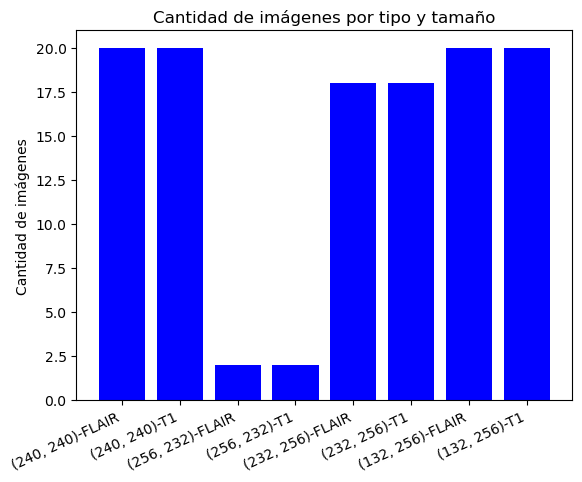

In [75]:
size_location_counts = {}
locations=["FLAIR","T1","FLAIR","T1","FLAIR","T1","FLAIR","T1"]
for size,label in zip(image_sizes, markers):
    if (size,label) not in size_location_counts:
        size_location_counts[(size,label)] = 0
    size_location_counts[(size,label)] += 1
    
print(size_location_counts)

plt.bar(range(len(locations)), list(size_location_counts.values()), color='blue')
plt.ylabel('Cantidad de imágenes')
plt.title('Cantidad de imágenes por tipo y tamaño')
plt.xticks(range(len(size_location_counts.keys())), [f"{size}-{label}" for(size,_),label in zip(size_location_counts,locations)], rotation=25, ha='right')
plt.show()

Como podemos observar tanto las flair y las t1 de cada lugar poseen el mismo tamaño. Luego encontramos el caso de Singapur con las 2 FALIR y 2 T1 que se encuentran invertidas. 

Al tener tres tamaños diferentes de imagen para cada lugar se deberá realizar un redimensionamiento de las imágenes. 

## Soluciones consideradas

### Modelos a usar 

#### U-NET
La U-net[4] es una red neuronal es empleada para la segmentación de imágenes médicas. Para la segmentación emplearé un modelo preentrenado para la segmentación de MRI cerebrales. Esta red se encuentra en el siguiente enlace: https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

La red tiene la siguiente estructura: 

Encoder:  Típica CNN con convoluciones 3x3, RELU, Maxpooling 2x2 y Stride 2. Cada vez que se hace un maxpooling se dobla el número de canales.

Decoder: Upsampling de los feature map, se aplican convoluciones 2x2 que dividen a la mitad los mapas. Dos convoluciones 3x3 seguidos de una RELU. La útilma capa es una convolucion 1x1. Se reconstruye la segementación de la imagen.

Después de cada convolución 3x3 se agrega BatchNormalization que mejora los resultados.

Contiene "skip-connections" que conectan las capas del encoder y el decoder entre si para transferir información más detallada de la imagen a las capas del decodificador.

#### SAM [5]

Este modelo es un proyecto de META. Se inspira en los modelos de inteligencia artificial del lenguaje natural(NLP). Las tareas que realiza consisten en traducir los prompts de NLP a segmentación. Los prompts son una serie de puntos, una bounding box  o máscara, cualquier información que indique que segmentar en una imagen. Posteriormente, se devuelve una segmentación válida al prompt. 

El modelo SAM tiene los siguientes componentes: 

- Image Encoder: Se trata de un Vision Transformer( ViT) basado en la idea de una MAE( Masked Autoencoder) ninimimamente adapatado para procesor inputs de alta resolución. Se ejecuta una vez por imagen.

- Prompt encoder: Se consideran dos tipos de "prompts":
    - Puntos, bounding boxes y texto. Se llaman "sparse". Se representan mediante codificadores posicionales sumado aquello aprendido para cada tipo de prompt y texto de forma libre con un encoder de texto llamado CLIP.
    - O máscaras("dense"). Se incorporan empleando convoluciones i se concatenan con la codificación obtenida en el image encoder. 


- Mask decoder: Este descodificador asigna eficientemente los embeddings de una imagen, de un prompt y el token de salida a una máscara. 

Además posee las siguientes características: 

- Resuelve la ambigüedad: Con un solo output el modelo promedia diversas máscaras si se ha dado un prompt ambigüo. El modelo se debe modificar para que prediga múltiples máscaras de salida para un solo prompt. 

- Eficiencia: El diseño del modelo se centra en la eficiencia. Con un embedding de imagen precalculada, el encoder y el mask decoder funcionan rápidamente en un navegador web, empleando la CPU ( aprox 50 ms). Significa que el modelo opera sin problemas y rápidamente y en tiempo real. 

- Perdidas y entrenamiento:  La predicción de máscaras utiliza una combinación lineal de pérdida focal y otra de dice. Se crea una configuración interactiva mediante un muestreo aleatorio de prompts en 11 rondas de máscaras. 

### Métricas
Para evaluar el modelo obtenido emplearé:

- Dice Coefficient: Dos veces la intersección entre la anotación o ground truth y la máscara predicha, dividida por la suma del ground_truth y la máscara predicha. Cuánto más cercano al valor 1, significa que el modelo predice mejores resultados, ya que el groundtruth y la máscara predicha son más parecidas. 
- Dice Loss: Se trata de la diferencia entre la máscara y el groundtruth. Cuánto más cerca se encuentre del 0 mejor, ya que es 1-Dice coefficiente.

A continuación se muestra la función que se empleará: 

In [7]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

## Conjuntos Train y Test

Como hemos comentado anteriormente, las imágenes poseen tamaños diversos. Por ello inicialmente, seràn redimensonadas a un tamaño de 128x128. El siguiente fragmento de código transforma la imagen a tensor y redimensiona a 128x128. 

Por otra parte, la máscara se redimensiona empleando el método de inteporlación NEAREST. Este método asigna el valor del píxel más cercano a la imagen original.  La palicación de este método nos beneficia ya que permite mantener los límites de la cada clase en la máscara segmentada y evitar la introducción de cambios en la información de las máscaras.[2]

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True),
    ])

transform_label=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True, interpolation= transforms.InterpolationMode.NEAREST),
])

En la siguiente clase, se muestra como se crea el dataset. Se pasa por parámetro las imágenes, las máscaras segmentadas(labels) y los dos transformadores. 


In [9]:
class Data(Dataset):
    def __init__(self, images, labels, transform, transform_label):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        self.transform_label = transform_label
        
    def __len__(self): 
        return self.len
    
                
    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index]
        
        img = nib.load(path)
        image= img.get_fdata() 

        lab = nib.load(label)
        label_img =  lab.get_fdata()
       
        label_img[label_img==2]=0
       
        
        image = self.transform(image)
        label_img = self.transform_label(label_img)
        image= image[image.shape[0] // 2,:,:].unsqueeze(0)
        label_img= label_img[label_img.shape[0] // 2,:,:].unsqueeze(0)

      
        
        
        return image,label_img    

Creamos los dos datasets de train  y test. En primer lugar realizaremos la segemntación con FLAIR, posteriormente emplearemos T1. 

In [10]:
##FLAIR
train_data = Data(TRAINING_DICT.get("pathsFLAIR"), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_data.len)
val_data = Data(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

60
110


Creamos los dataloaders para cada uno de los conjuntos. Estos sirven para cargar los datos en lotes durante el entrenamiento. Si usamos shuffle se mezclan los lotes de forma aleatoria. 

In [11]:
train_dl = DataLoader(train_data, batch_size=5, shuffle=True)
test_dl = DataLoader(val_data, batch_size=15, shuffle=True)

# Referencias 

[1] Kuijf, Hugo; Biesbroek, Matthijs; de Bresser, Jeroen; Heinen, Rutger; Chen, Christopher; van der Flier, Wiesje; Barkhof; Viergever, Max; Biessels, Geert Jan, 2022, "Data of the White Matter Hyperintensity (WMH) Segmentation Challenge", https://doi.org/10.34894/AECRSD, DataverseNL, V1

[2]J. Miranda Bautista, I. Garrido Morro, P. Fernández García, I. Herrera Herrera,"Hiperintensidad en secuencia FLAIR del LCR en el espacio subaracnoideo: diagnósticos diferenciales", Enero,  2022, https://www.elsevier.eses-revista-radiologia-119-avance-resumen-hiperintensidad-secuencia-flair-del-lcr-S0033833822000534?newsletter=true, Servicio de Radiodiagnóstico, HGU Gregorio Marañón, Madrid, España

[3]https://saishnp.com/2021/04/20/el-contraste-en-imagen-de-resonancia-magnetica/

[4]Olaf Ronneberger, Philipp Fischer, and Thomas Brox; May, 2015; "U-Net: Convolutional Networks for Biomedical Image Segmentation",https://arxiv.org/pdf/1505.04597.pdf,

[5]https://arxiv.org/pdf/2304.02643.pdf


# ENTRENAMIENTO 

A continuación vamos a realizar el entrenamiento del modelo para segmentar las imágenes. Se ha creado la siguiente función que nos permite setear los datasets y los dataloaders al pasar por parámetro un String con la key que indica que path de imagen se requiere y los transformers tanto de la imagen como del las máscaras: 

In [12]:
random.seed(0)
def dataLoaders(path:str,transform, transform_label):    
    train_data = Data(TRAINING_DICT.get(path), TRAINING_DICT.get("mask"), transform, transform_label)
    print(train_data.len)
    val_data = Data(TEST_DICT.get(path), TEST_DICT.get("mask"), transform, transform_label)
    print(val_data.len)
    train_dl = DataLoader(train_data, batch_size=5, shuffle=True)
    test_dl = DataLoader(val_data, batch_size=15, shuffle=True)
    return train_data, val_data, train_dl,test_dl 

Probamos el método seleccionando las radiografías de tipo FLAIR. 

In [13]:
_,val_data,train_dl,test_dl = dataLoaders("pathsFLAIR",transform, transform_label)

60
110


Vamos a crear una función para setear el tamaño de los transformers: 

In [14]:
def transform_setter(x: int):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((x,x), antialias=True),
    ])

    transform_label=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((x,x), antialias=True, interpolation= transforms.InterpolationMode.NEAREST),
    ])  
    return transform, transform_label

In [15]:
transform, transform_label=transform_setter(128)

Vamos a observar la estructura del batch: 

In [16]:
iterador =  iter(test_dl)
features, labels = next(iterador)

print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature batch shape: torch.Size([15, 1, 128, 128])
Labels batch shape: torch.Size([15, 1, 128, 128])


Del siguiente repositorio de github se ha obtenido un modelo U-NET codificado en python: [https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py]. Realizamos el correspondiente import y indicamos que si cuda está disponible se emplee:

In [17]:
from unet import UNet 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Inicializamos el modelo. La imágenes que pasemos tienen un solo canal, han sido transformadas para solo obtener el eje transversal. La salida será de un solo canal también. Inicialmente, se establecen 32 features. 

In [18]:
model = UNet(in_channels=1,out_channels=1, init_features=32)

print(model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Se muestra la función de entrenamiento y validación del modelo:

In [19]:
def traintestpipeline(epochs: int, optim: Adam, criterion: DiceLoss, min_loss: int, name: str):
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))
    pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
    for epoch in pbar:
        
        train_loss = 0 
        val_loss = 0  
        
        model.train()                                                  
        for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        

            input_img= input_img.to(device).float()
            target = target.to(device)
            
            
            output = model(input_img)
            loss = criterion(output, target)
            loss.backward()                                            
            optim.step()                                               
            optim.zero_grad()     
            
            train_loss += loss.item()    
                                                        
        model.eval()   
        with torch.no_grad():                                          
            for input_img, target in test_dl: 
                input_img = input_img.to(device).float()
                target = target.to(device)
                
                output = model(input_img)                                   
                loss = criterion(output, target)   
                val_loss += loss.item()  
        
        # RESULTATS
        train_loss /= len(train_dl)
        t_loss[epoch-1] = train_loss
        
        val_loss /= len(test_dl)   
        v_loss[epoch-1] = val_loss
        if(v_loss[epoch-1]<min_loss):
            min_loss=v_loss[epoch-1]
            torch.save(model.state_dict(), name)  
        # VISUALITZACIO DINAMICA
        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

## Segmentación tamaño de imagen 128x128

### FLAIR

En estos primeros modelos establecemos un tamaño de imagen de 128x128. Se emplea el optimizador ADAM y inicialmente se realizarán 65 épocas. En la función de entrenamiento, se establece que aquella época en el que el modelo tenga la pérdida mínima sobre el conjunto de validación será el modelo que se almacene.  

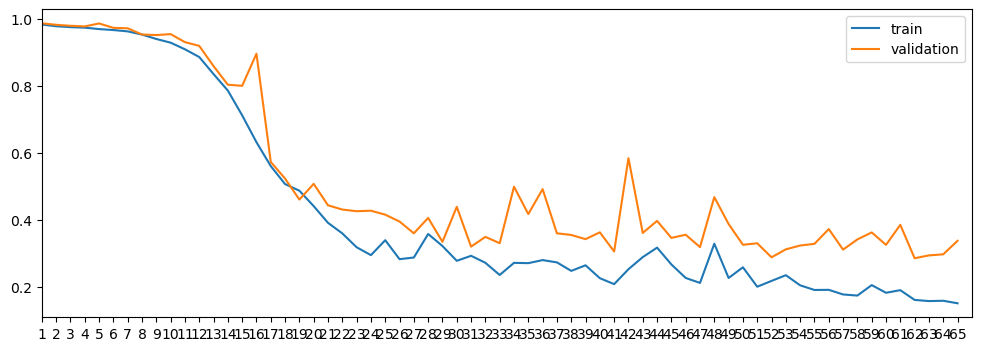

Epoch:65 Training Loss:0.150308102963824 Validation Loss:0.336796437106061: 100%|██████████| 65/65 [32:14<00:00, 29.76s/it]    


In [437]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"flair_128.pt")


Las próximas líneas nos permiten cargar el modelo para hacer pruebas:

In [144]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("flair_128.pt"))
mmodel.eval();

Calculamos el dice coefficient:

In [20]:
def diceCoeff(y_true, y_pred):
    y_pred = y_pred[:, 0].contiguous().view(-1)
    y_true = y_true[:, 0].contiguous().view(-1)
    intersection = (y_pred * y_true).sum()
    dsc = (2. * intersection + 1) / (
        y_pred.sum() + y_true.sum() + 1
    )
    return dsc

In [21]:
def calculatediceCoeff(mmodel):
    mmodel.eval()  
    total=0 
    with torch.no_grad():                                          
        for input_img, target in test_dl: 
            input_img = input_img.to(device).float()
            target = target.to(device).float()
            
            output = mmodel(input_img)                                   
            total += diceCoeff(target,output)
    total/=len(test_dl)
    print("Dice coefficient", total)    

Para ser el primer modelo y con un tamaño de imagen pequeño hemos obtenido un 71.12%. Este porcentaje es la media del dice coefficient de cada batch. Como usamos un dataloader con shuffle a true durante el entrenamiento, el porcentaje obtenido está basado en la ordenación aleatoria de las imágenes.

In [22]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7112)


Vamos a comprobar el total del conjunto de validación. Para reutilizar la función del cálculo diceCoefficent he creado un dataloader de test con batch_size igual al conjunto de imágenes del conjunto de validación:

In [145]:
test_dl= DataLoader(val_data, batch_size=110, shuffle=True)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.6925)


No hay una diferencia significativa.

Vamos a observar una pequeña muestra de la segmentación:

In [22]:
def generador(loader):
    for data, target in loader:
        data, target = data.to(device).float(), target.float().to(device)
        yield data, target 
def showsegmentation(test_dl, mmodel):               
    with torch.no_grad():
        gen = generador(test_dl)

        data, true_labels = next(gen)

        mmodel.eval()

        output = mmodel(data)

        _,axs =plt.subplots(1,2)
        true_label=true_labels[0]
    

        axs[0].imshow(torch.squeeze(output[0]), cmap='gray')
        axs[0].set_title("Output")
        axs[1].imshow(true_label[true_label.shape[0] // 2, :,:], cmap='gray')
        axs[1].set_title("Label Mask")
        
        plt.show()

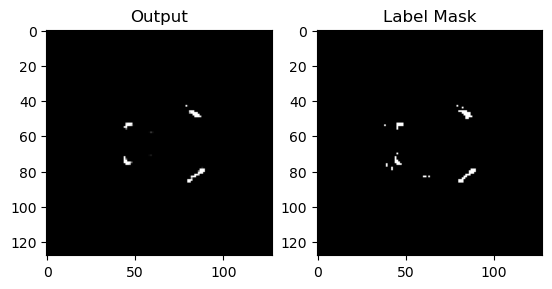

In [24]:
showsegmentation(test_dl, mmodel)

Como podemos observar las manchas pequeñas son más pequeñas de detectar, mientras que las grandes no las define del todo correctamente. Sin embargo, para ser el primer modelo está bien. 

### T1

Ya hemos creado un primer modelo con las imágenes de tipo FLAIR, ahora haremos uno con T1.

In [146]:
transform,transform_label= transform_setter(128)
train_data,val_data,train_dl,test_dl = dataLoaders("pathsT1",transform, transform_label)

60
110


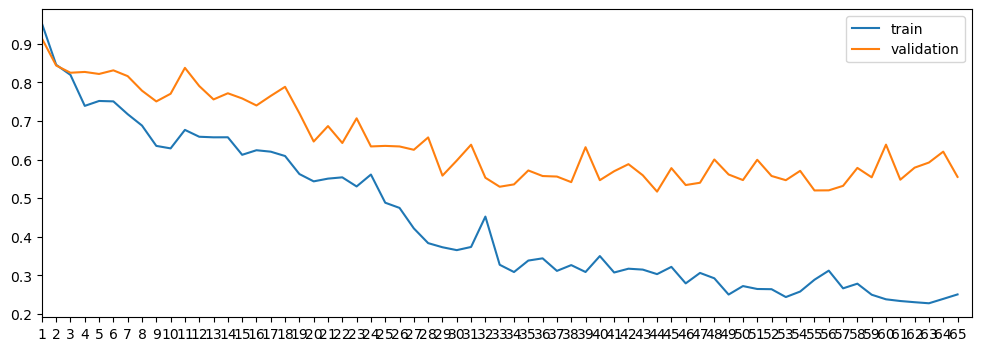

Epoch:65 Training Loss:0.2507532207701561 Validation Loss:0.5550564741604728: 100%|██████████| 65/65 [27:00<00:00, 24.93s/it]


In [444]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"T1_128.pt")

Como podemos observar, el modelo no funciona bien con el conjunto de validación. Las última épocas ya no aprende, mientras que el conjunto de entrenamiento roza una pérdida del 0,2.

In [147]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("T1_128.pt"))
mmodel.eval();

Como podemos observar hay demasiada diferencia con el modelo de las imágenes FLAIR. Este modelo es pésimo, pero debe ser por la calidad de las imágenes, ya que las manchas son apenas imperceptibles en T1 ( a diferencia de FLAIR)

In [446]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4495)


Total:

In [148]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4652)


Como podemos observar apenas detecta las manchas, aunque estás sean bastantes grandes el modelo no consigue segmentarlas: 

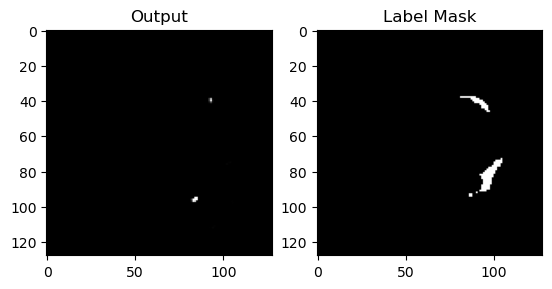

In [447]:
showsegmentation(test_dl, mmodel)

### Modelo entrenado con los dos conuntos de imagen FLAIR Y T1

Vamos a observar que pasaría si unisemos los dos conjuntos de imágenes para entrenar un modelo;

In [150]:
train_data = Data(TRAINING_DICT.get('pathsFLAIR'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_data.len)
val_data = Data(TEST_DICT.get('pathsFLAIR'), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

train_dataT1 = Data(TRAINING_DICT.get('pathsT1'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_dataT1.len)
val_dataT1 = Data(TEST_DICT.get('pathsT1'), TEST_DICT.get("mask"), transform, transform_label)
print(val_dataT1.len)

60
110
60
110


Usamos concatDataset para unir los datasets de FLAIR y T1, y seteamos los dataloaders con el nuevo dataset:

In [151]:
train_data = ConcatDataset([train_data, train_dataT1])
print(len(train_data))
val_data = ConcatDataset([val_data, val_dataT1])
print(len(val_data))

train_dl = DataLoader(train_data, batch_size=5, shuffle=True)
test_dl = DataLoader(val_data, batch_size=15, shuffle=True)

120
220


Hemos obtenido el doble de imágenes. Vamos a entrenar el modelo:

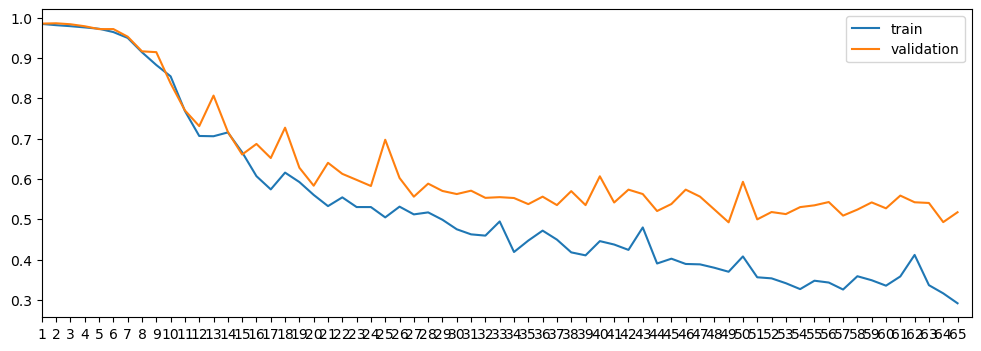

Epoch:65 Training Loss:0.29161101151208196 Validation Loss:0.5172652216299982: 100%|██████████| 65/65 [1:03:14<00:00, 58.38s/it]


In [98]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"conjunto128.pt")

Como podemos observar ocurre algo similar que con el modelo T1. Probablemente si hubieramos establecidos más épocas el conjunto de entrenamiento hubiera rozado casi un 0 de perdida mientras que el conjunto de validación no hubiera disminuido la perdida, ya que el modelo ya no aprende.

In [152]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("conjunto128.pt"))
mmodel.eval();

Como podemos observar las imágenes T1 perjudican a la eficiencia del modelo, haciendo que se obtenga un dice coefficient de 50.24%

Dice coefficient tensor(0.5024)


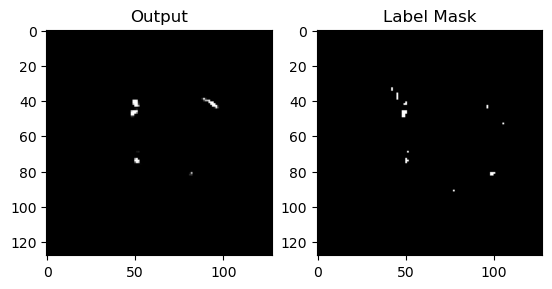

In [45]:
calculatediceCoeff(mmodel)
showsegmentation(test_dl, mmodel)

In [153]:
test_dl= DataLoader(val_data, batch_size=220)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.5018)


## Segmentación tamaño de imagen 256x256

En primer lugar, establecemos que el tamaño de imagen debe ser de 256:

In [18]:
transform,transform_label= transform_setter(256)

In [171]:
train_data, val_data, train_dl,test_dl = dataLoaders("pathsFLAIR",transform, transform_label)

60
110


Entrenamos el modelo: 

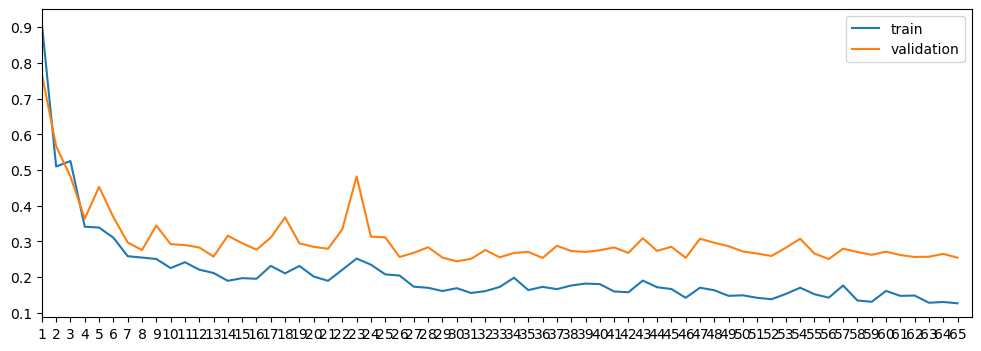

Epoch:65 Training Loss:0.1267152813133782 Validation Loss:0.2544875064082016: 100%|██████████| 65/65 [1:01:31<00:00, 56.79s/it] 


In [448]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"flair_256.pt")

Como podemos observar con este tamaño de imagen, el modelo aprende muy rápido. A partir de la iteración 35, las pérdidas de ambos conjuntos se mantienen lineales. Por tanto, podríamos crear el modelo con menos iteraciones

In [172]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("flair_256.pt"))
mmodel.eval();

Como vemos a subido a un 75.38%, ha mejorado con respecto al modelo anterior:

In [450]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7538)


Total:

In [173]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7473)


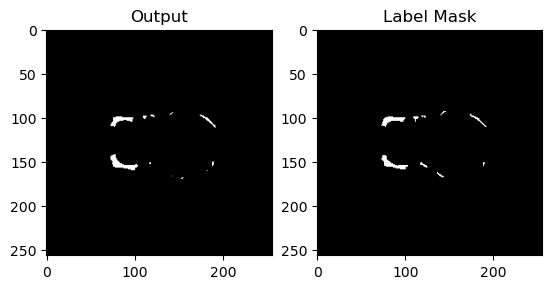

In [451]:
showsegmentation(test_dl, mmodel)

Como podemos observar, continua teniendo dificultades para definir correctamente las manchas o distinguir las pequeñas.

#### Menos épocas

Como hemos mencionado en el apartado anterior, vamos a crear un modelo empleando menos iteración, en total 35:

In [19]:
_, val_data,train_dl,test_dl = dataLoaders("pathsFLAIR",transform, transform_label)

60
110


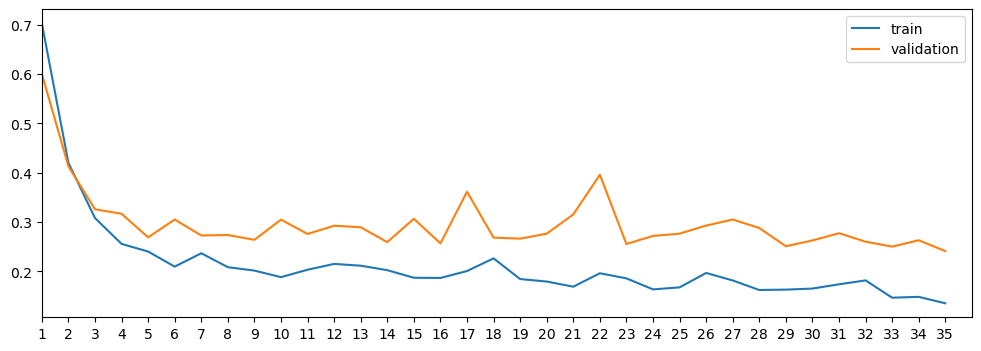

Epoch:35 Training Loss:0.13539810090017335 Validation Loss:0.2411001428073365: 100%|██████████| 35/35 [33:37<00:00, 57.65s/it]


In [102]:
epochs = 35
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"Flair256iter35.pt")

Como vemos, aprende muy rápido y como en el modelo anterior casi al final se mantiene una misma pérdida.

In [20]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("Flair256iter35.pt"))
mmodel.eval();

Empleando un menor número de iteraciones hemos conseguido un resultado parecido

In [91]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7591)


In [176]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7507)


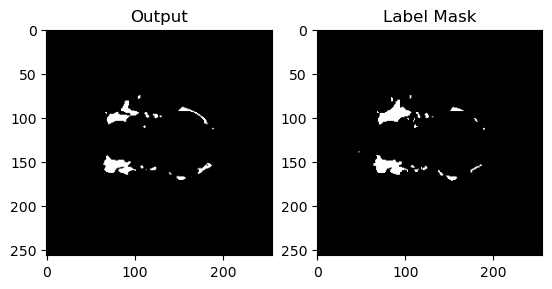

In [27]:
showsegmentation(test_dl, mmodel)

Hemos obtenido una segmentación similar. 

#### Más features

Como el modelo anterior ha conseguido un dice coefficient bastante elevado, vamos a comprobar como afecta si cambiamos el número de features iniciales: 

In [177]:
model = UNet(in_channels=1,out_channels=1, init_features=64)

In [178]:
transform, transform_label= transform_setter(256)
_, val_data,train_dl,test_dl = dataLoaders("pathsFLAIR",transform, transform_label)

60
110


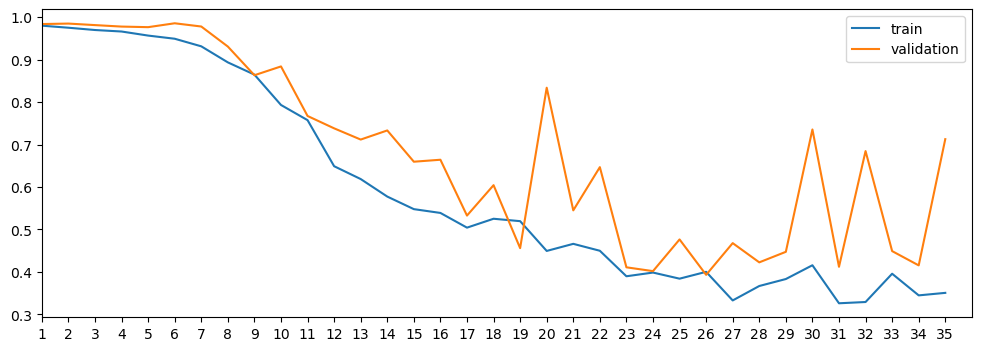

Epoch:35 Training Loss:0.35050045946442215 Validation Loss:0.7126976306268812: 100%|██████████| 35/35 [1:09:35<00:00, 119.29s/it] 


In [48]:
epochs = 35
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"Flair256feat64.pt")

Como podemos observar, no funciona demasiado bien sobre el conjunto de validación hay demasiado variación.

In [179]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("Flair256feat64.pt"))
mmodel.eval();

Hemos obtenido un dice coefficient de 61.74%. Bastante inferior al modelo anterior

Dice coefficient tensor(0.6174)


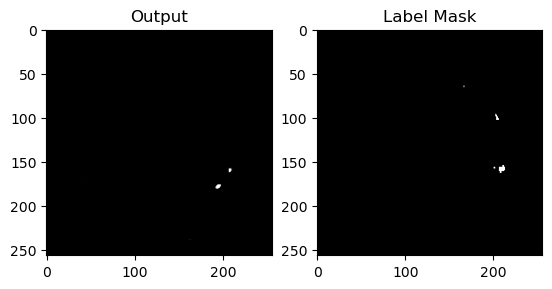

In [50]:
calculatediceCoeff(mmodel)
showsegmentation(test_dl, mmodel)

In [180]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.6082)


#### Menos features

La siguiente prueba empleará 24 features:

In [181]:
model = UNet(in_channels=1,out_channels=1, init_features=24)

In [188]:
transform, transform_label= transform_setter(256)
_, val_data,train_dl,test_dl = dataLoaders("pathsFLAIR",transform, transform_label)

60
110


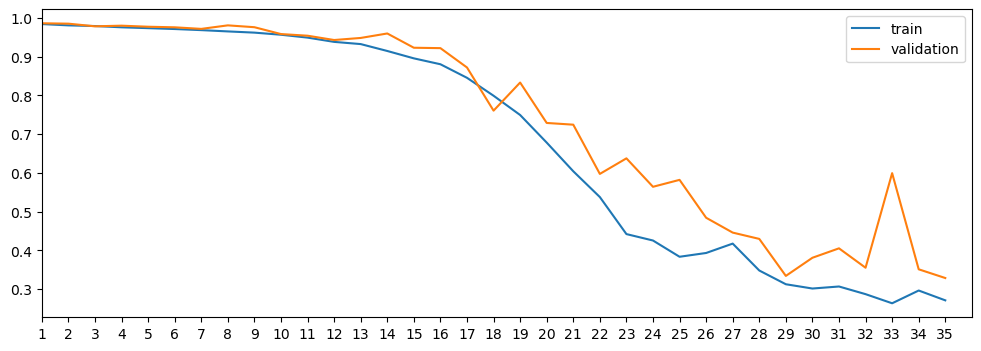

Epoch:35 Training Loss:0.27076304690604197 Validation Loss:0.328414965405571: 100%|██████████| 35/35 [25:18<00:00, 43.39s/it]


In [52]:
epochs = 35
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"Flair256feat24.pt")

Con esta cantidad de features, parece que funciona mejor con el conjunto de validación. Quizás si añadimos más iteraciones conseguiremos que la pérdida disminuya. 

In [189]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("Flair256feat24.pt"))
mmodel.eval();

El modelo es mejor que el anterior: 

Dice coefficient tensor(0.6609)


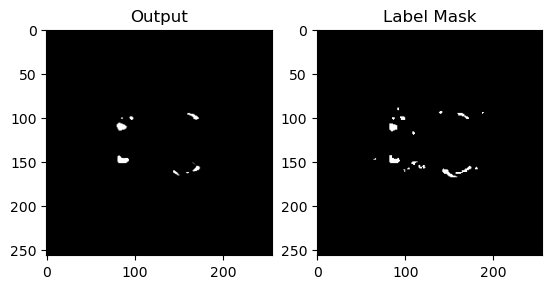

In [59]:
calculatediceCoeff(mmodel)
showsegmentation(test_dl, mmodel)

In [190]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.6586)


#### Añadir más épocas

In [191]:
transform, transform_label= transform_setter(256)
_, val_data,train_dl,test_dl = dataLoaders("pathsFLAIR",transform, transform_label)

60
110


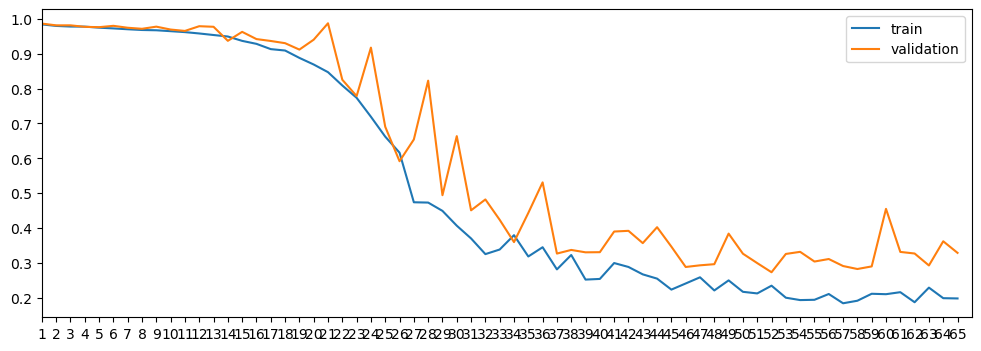

Epoch:65 Training Loss:0.19868039543777552 Validation Loss:0.32926937094625297: 100%|██████████| 65/65 [50:03<00:00, 46.20s/it]


In [75]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"Flair256feat24iter65.pt")

In [192]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("Flair256feat24iter65.pt"))
mmodel.eval();

Dice coefficient tensor(0.7162)


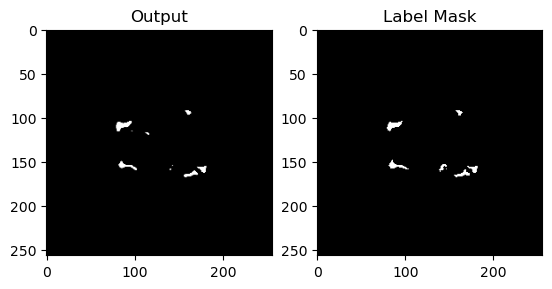

In [77]:
calculatediceCoeff(mmodel)
showsegmentation(test_dl, mmodel)

In [193]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7256)


### T1

Restablecemos el modelo anterior a 32 features. 

In [18]:
model = UNet(in_channels=1,out_channels=1, init_features=32)

Vamos a establecer las radiografías de tipo T1. 

In [23]:
transform, transform_label= transform_setter(256)
_, val_data,train_dl,test_dl =  dataLoaders("pathsT1",transform, transform_label)

60
110


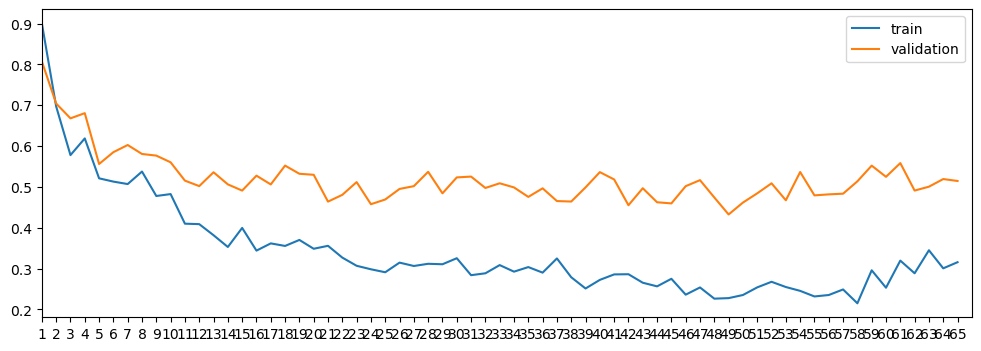

Epoch:65 Training Loss:0.3155944506948055 Validation Loss:0.5145235050724827: 100%|██████████| 65/65 [56:00<00:00, 51.71s/it]


In [452]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"T1_256.pt")

Como podemos observar las primeras épocas aprende bastante rápido. Luego se mantiene y no dismnuye.

In [199]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("T1_256.pt"))
mmodel.eval();

Hemos aumentado considerablemente la eficacia a un 53.96%:

In [454]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.5396)


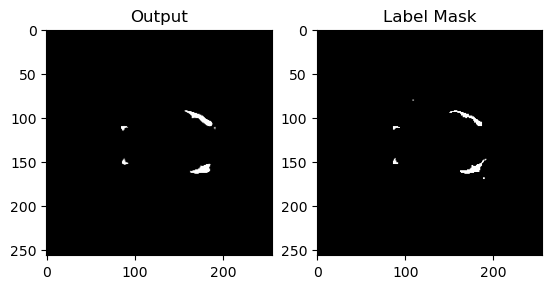

In [455]:
showsegmentation(test_dl, mmodel)

Esta vez se puede observar mejor la segmentación, sin embargo no se observan las manchas diminutas ni las de mayor tamaño están del todo definidas.

In [203]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.5092)


### Conjunto FLAIR y T1

Creamos los datasets y los dataloaders:

In [27]:
train_data = Data(TRAINING_DICT.get('pathsFLAIR'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_data.len)
val_data = Data(TEST_DICT.get('pathsFLAIR'), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

train_dataT1 = Data(TRAINING_DICT.get('pathsT1'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_dataT1.len)
val_dataT1 = Data(TEST_DICT.get('pathsT1'), TEST_DICT.get("mask"), transform, transform_label)
print(val_dataT1.len)
train_data = ConcatDataset([train_data, train_dataT1])
print(len(train_data))
val_data = ConcatDataset([val_data, val_dataT1])
print(len(val_data))

train_dl = DataLoader(train_data, batch_size=5, shuffle=True)
test_dl = DataLoader(val_data, batch_size=15, shuffle=True)

60
110
60
110
120
220


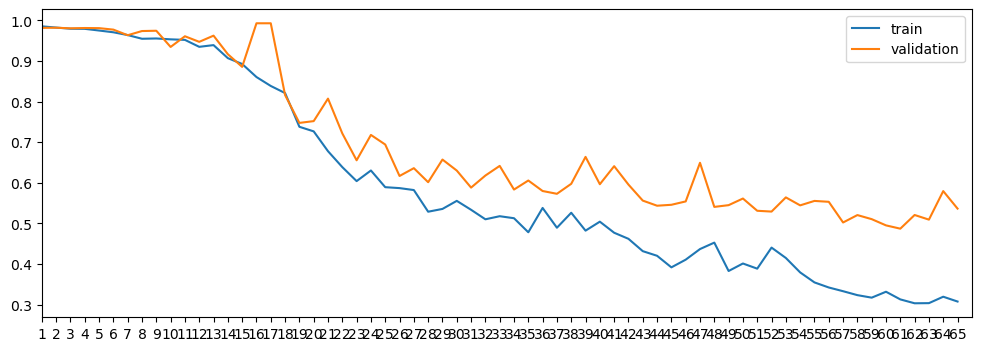

Epoch:65 Training Loss:0.3073392420603424 Validation Loss:0.5362675393626177: 100%|██████████| 65/65 [2:03:49<00:00, 114.30s/it]


In [80]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"conjunto256.pt")

In [28]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("conjunto256.pt"))
mmodel.eval();

Hemos conseguido una precisión 51.54%

Dice coefficient tensor(0.5154)


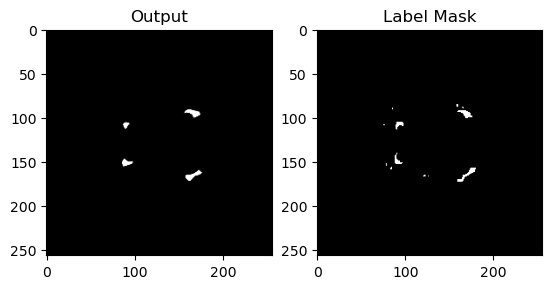

In [84]:
calculatediceCoeff(mmodel)
showsegmentation(test_dl, mmodel)

In [31]:
test_dl= DataLoader(val_data, batch_size=220)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.5151)


## Segmentación tamaño de imagen 384X384

Inicializamos el tamaño de las imágenes a 384x384

In [18]:
transform, transform_label= transform_setter(384)
_, val_data,train_dl,test_dl = dataLoaders("pathsFLAIR",transform, transform_label)

60
110


### FLAIR

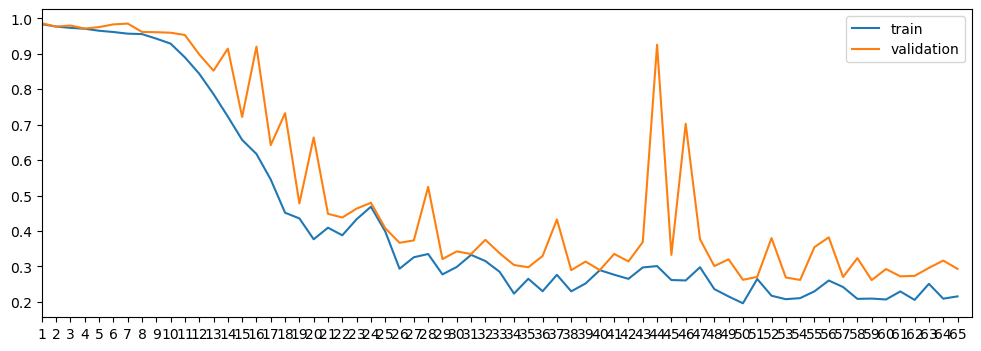

Epoch:65 Training Loss:0.21545893941329272 Validation Loss:0.29302362588903397: 100%|██████████| 65/65 [1:58:44<00:00, 109.61s/it]


In [489]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"flair_384.pt")

El modelo hace overfitting sobre la iteración 28. 

In [19]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("flair_384.pt"))
mmodel.eval();

El modelo ha empeorado. 

In [491]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7342)


In [20]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7208)


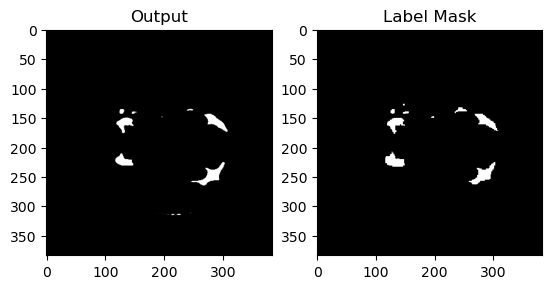

In [492]:
showsegmentation(test_dl, mmodel)

Por lo tanto, el mejor resultado obtenido con FLAIR es empleando el tamaño de imagen 256x256

### T1

In [17]:
transform, transform_label= transform_setter(384)
_, val_data,train_dl,test_dl =dataLoaders("pathsT1",transform, transform_label)

60
110


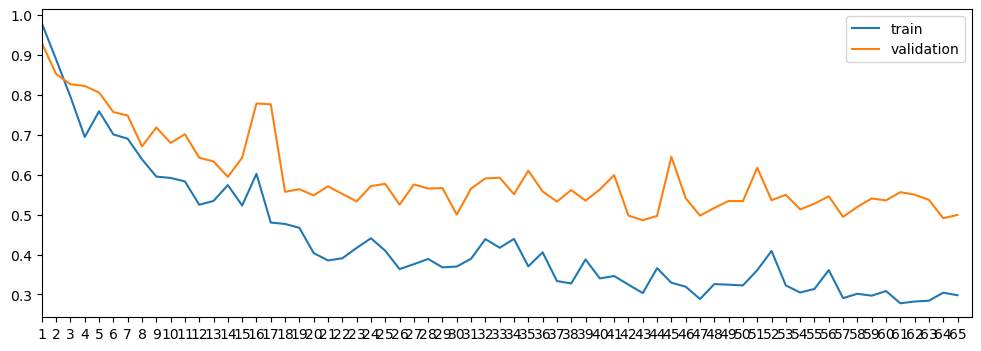

Epoch:65 Training Loss:0.29814674516588735 Validation Loss:0.49938067764983246: 100%|██████████| 65/65 [1:53:07<00:00, 104.43s/it]


In [493]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"T1_384.pt")

A partir de la iteración 40, la pérdida del conjunto de validación apenas disminuye. 

In [22]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("T1_384.pt"))
mmodel.eval();

La precisión ha empeorado

In [495]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.5032)


In [23]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.5129)


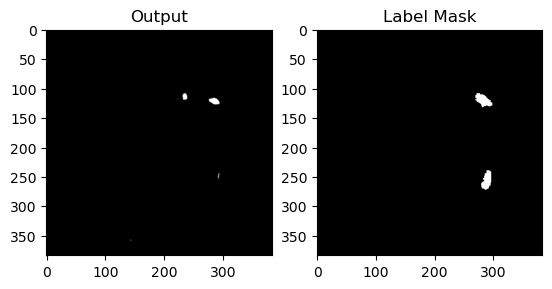

In [496]:
showsegmentation(test_dl, mmodel)

Con T1 también llegamos a la conclusión de que el mejor tamaño de imagen es 256x256.

#### Conjunto de FLAIR y T1


In [18]:
train_data = Data(TRAINING_DICT.get('pathsFLAIR'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_data.len)
val_data = Data(TEST_DICT.get('pathsFLAIR'), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

train_dataT1 = Data(TRAINING_DICT.get('pathsT1'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_dataT1.len)
val_dataT1 = Data(TEST_DICT.get('pathsT1'), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

60
110
60
110


In [19]:
train_data = ConcatDataset([train_data, train_dataT1])
print(len(train_data))
val_data = ConcatDataset([val_data, val_dataT1])
print(len(val_data))

train_dl = DataLoader(train_data, batch_size=5, shuffle=True)
test_dl = DataLoader(val_data, batch_size=15, shuffle=True)

120
220


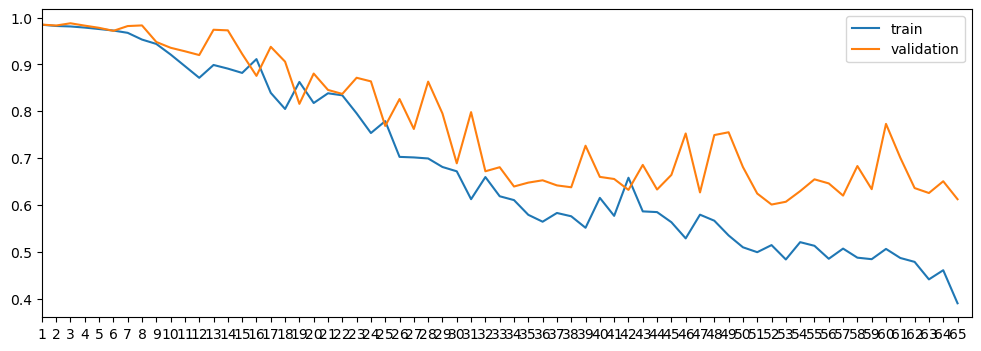

Epoch:65 Training Loss:0.3898345368743356 Validation Loss:0.6121319970603835: 100%|██████████| 65/65 [3:43:56<00:00, 206.72s/it]


In [21]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"conjunto384.pt")

Como podemos observar hay un punto en que el conjunto de valdiación no disminuye la perdida, mientras que el de entrenamiento sigue bajando.

In [20]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("conjunto384.pt"))
mmodel.eval();

A pesar de que los modelos individuales han conseguido mejor precisión que los modelos individuales del tamaño de imagen 128x128. En comparación con el modelo de 128x128 que emplea tanto FLAIR como T1, este modelo con tamaño 384x384 ha conseguido un dice coefficient inferior. 

In [27]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4057)


In [21]:
test_dl= DataLoader(val_data, batch_size=220)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4020)


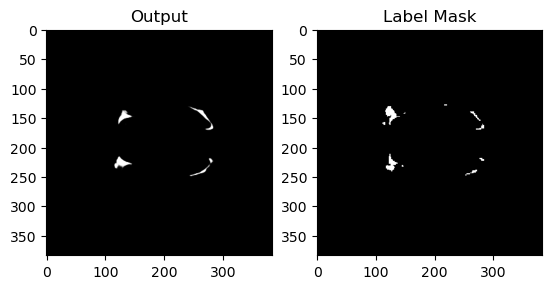

In [30]:
showsegmentation(test_dl, mmodel)

# Transfer learning 

El modelo que utilizamos ha sido entrenado para segmentar tumores cerebrales. Quizás si congelamos los pesos podamos emplearlo y obtener una mayor eficacia. 

### Congelar pesos encoder y descongelar decoder

Cargamos el modelo de pytorch y modificamos los canales de entrada, ya que el modelo para segmentar tumores emplea 3 canales de entrada y nosotros de momento solo requerimos uno: 

In [20]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',in_channels=3, out_channels=1, init_features=32, pretrained=True)
model.encoder1.enc1conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
print(model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Using cache found in C:\Users\Aina/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


 Congelamos los pesos de todas las capas del modelo, descongelamos las capas del decoder así permitimos que se ajusten durante el entrenamiento. 

In [21]:
for param in model.parameters():
     param.requires_grad = False

for param in model.decoder1.parameters():
     param.requires_grad = True
for param in model.decoder2.parameters():
     param.requires_grad = True 
for param in model.decoder3.parameters():
     param.requires_grad = True         
for param in model.decoder4.parameters():
     param.requires_grad = True     

### FLAIR

Vamos a comenzar con FLAIR, con un tamaño de 256x256:

In [22]:
transform, transform_label= transform_setter(256)
_, val_data,train_dl,test_dl =dataLoaders("pathsFLAIR",transform, transform_label)

60
110


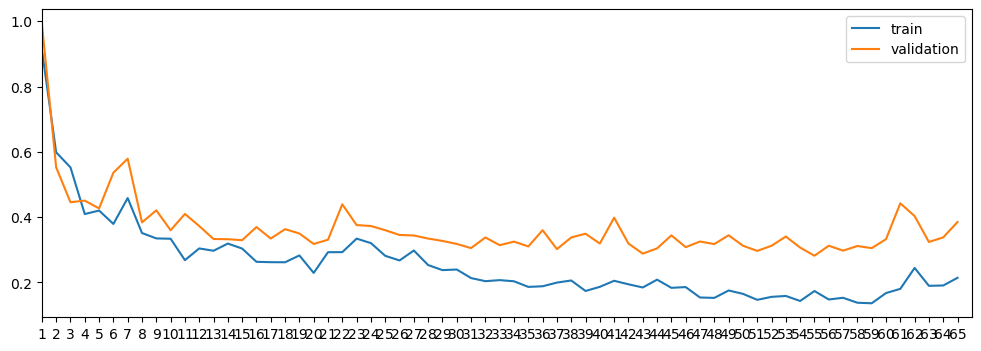

Epoch:65 Training Loss:0.21422566253148778 Validation Loss:0.3851839334190264: 100%|██████████| 65/65 [54:49<00:00, 50.61s/it] 


In [27]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"tlFLAIR256.pt")

Las primeras épocas disminuye rápidamente el dice loss y el resto de épocas no aprende apenas.

In [23]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("tlFLAIR256.pt"))
mmodel.eval();

Les separa un 5% con respecto al modelo entrenado desde 0. No es una diferencia demasiado grande.

In [29]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7105)


In [24]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7060)


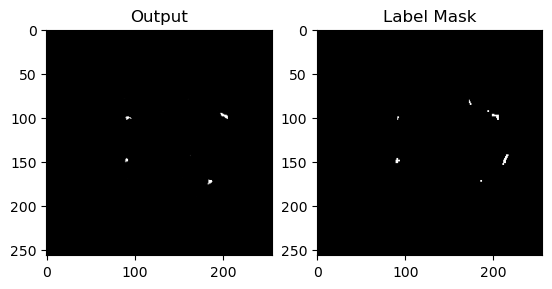

In [30]:
showsegmentation(test_dl, mmodel)

Como podemos observar, las manchas demasiado pequeñas aún no consigue distinguirlas

### T1 

In [25]:
transform, transform_label= transform_setter(256)
_, val_data,train_dl,test_dl = dataLoaders("pathsT1",transform, transform_label)

60
110


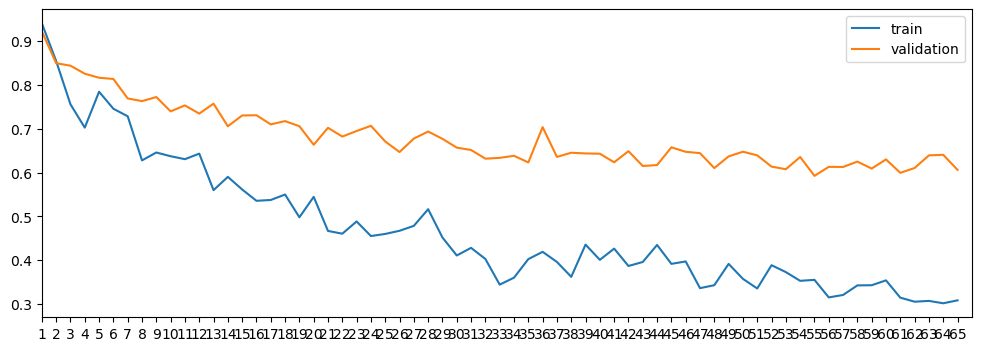

Epoch:65 Training Loss:0.3086246928642341 Validation Loss:0.60607437035576: 100%|██████████| 65/65 [49:16<00:00, 45.49s/it]  


In [31]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"tlT1256.pt")

Para T1 funciona muy mal. Apenas funciona con el conjunto de validación.

In [26]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("tlT1256.pt"))
mmodel.eval();

Conseguimos un dice coefficient pésimo

In [33]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4020)


In [27]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4018)


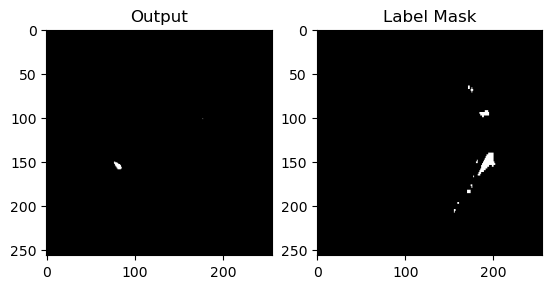

In [34]:
showsegmentation(test_dl, mmodel)

### Conjunto flair y t1

Obtenemos los dataset y dataloaders

In [28]:
train_data = Data(TRAINING_DICT.get('pathsFLAIR'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_data.len)
val_data = Data(TEST_DICT.get('pathsFLAIR'), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

train_dataT1 = Data(TRAINING_DICT.get('pathsT1'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_dataT1.len)
val_dataT1 = Data(TEST_DICT.get('pathsT1'), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

60
110
60
110


In [29]:
train_data = ConcatDataset([train_data, train_dataT1])
print(len(train_data))
val_data = ConcatDataset([val_data, val_dataT1])
print(len(val_data))

train_dl = DataLoader(train_data, batch_size=5, shuffle=True)
test_dl = DataLoader(val_data, batch_size=15, shuffle=True)

120
220


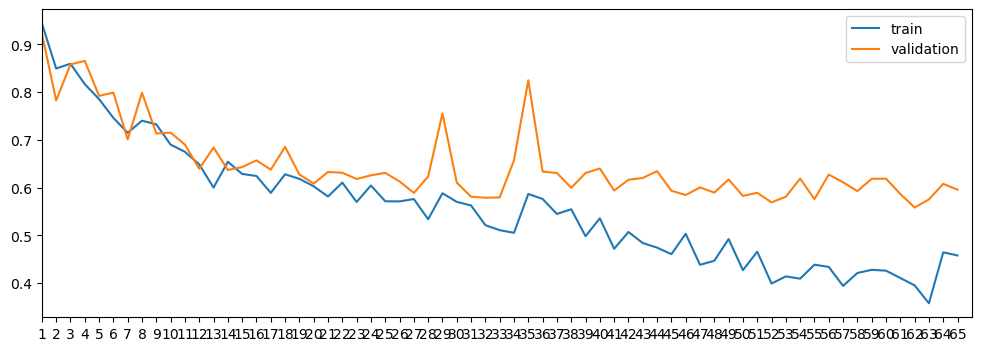

Epoch:65 Training Loss:0.4581466771925132 Validation Loss:0.5958596822273745: 100%|██████████| 65/65 [1:49:53<00:00, 101.44s/it] 


In [49]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"tlconjunto256.pt")

En la época 37-39 el conjunto de validación no disminuye su pérdida.

In [30]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("tlconjunto256.pt"))
mmodel.eval();

Modelo muy poco eficiente

In [51]:
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4289)


In [31]:
test_dl= DataLoader(val_data, batch_size=220)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4399)


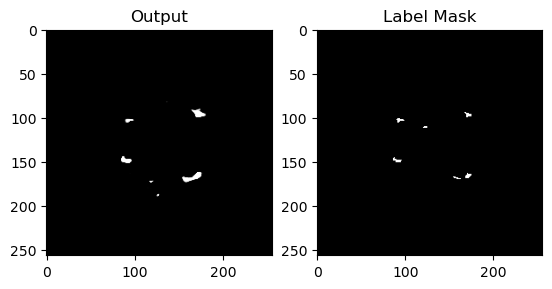

In [52]:
showsegmentation(test_dl, mmodel)

#### Congelar características encoder, entrenar última capa.

Cargamos el  modelo, congelamos los parámetros descongelamos el decoder y establecemos una nueva capa en la última capa para que esta sea entrenada:

In [32]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',in_channels=3, out_channels=1, init_features=32, pretrained=True)
model.encoder1.enc1conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)

for param in model.parameters():
     param.requires_grad = False
for param in model.decoder1.parameters():
     param.requires_grad = True
for param in model.decoder2.parameters():
     param.requires_grad = True 
for param in model.decoder3.parameters():
     param.requires_grad = True         
for param in model.decoder4.parameters():
     param.requires_grad = True 

model.encoder4=nn.Sequential(nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),nn. BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                             nn.ReLU(inplace=True),nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                             nn.ReLU(inplace=True))

Using cache found in C:\Users\Aina/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


##### FLAIR

In [33]:
transform, transform_label= transform_setter(256)
_, val_data, train_dl,test_dl = dataLoaders("pathsFLAIR",transform, transform_label)

60
110


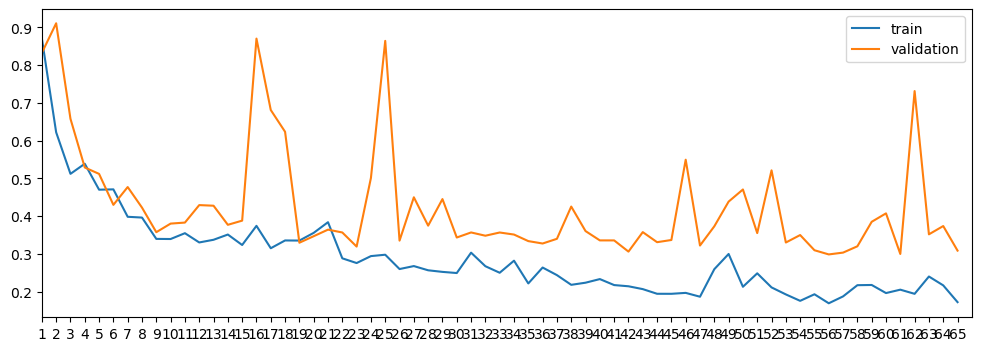

Epoch:65 Training Loss:0.17211207618544985 Validation Loss:0.30865806582697747: 100%|██████████| 65/65 [57:55<00:00, 53.47s/it]


In [54]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"UCFLAIR256.pt")

Como podemos observar la perdida del conjunto de entrenamiento se mantiene bastante estable, mientras que en el conjunto de validación hay demasiados picos y diferencias a lo largo del entrenamiento.

In [34]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("UCFLAIR256.pt"))
mmodel.eval();

Aún no es mejor que el modelo que hemos entrenado completamente:

Dice coefficient tensor(0.6999)


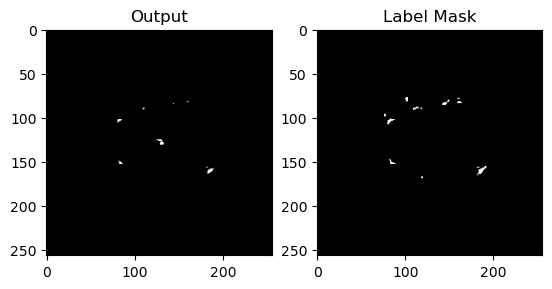

In [56]:
calculatediceCoeff(mmodel)
showsegmentation(test_dl, mmodel)

In [35]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.7002)


##### T1

In [36]:
transform, transform_label= transform_setter(256)
_, val_data, train_dl,test_dl = dataLoaders("pathsT1",transform, transform_label)

60
110


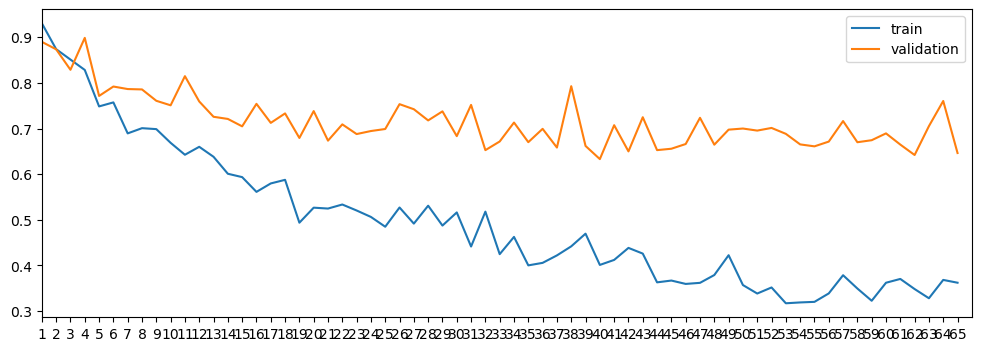

Epoch:65 Training Loss:0.36206225923048696 Validation Loss:0.6463104894425641: 100%|██████████| 65/65 [51:56<00:00, 47.94s/it]


In [57]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"UCT1256.pt")

Hay underfitting. 

In [37]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("UCT1256.pt"))
mmodel.eval();

El peor modelo en T1 obtenido hasta ahora.

Dice coefficient tensor(0.3574)


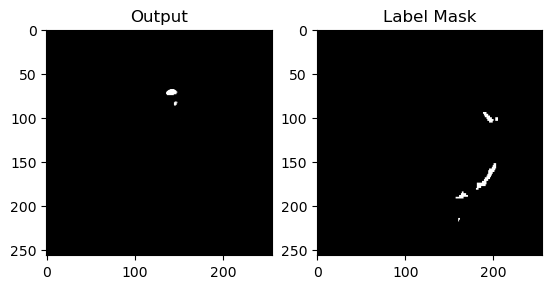

In [59]:
calculatediceCoeff(mmodel)
showsegmentation(test_dl, mmodel)

In [38]:
test_dl= DataLoader(val_data, batch_size=110)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.3483)


##### Conjunto flair y t1

In [39]:
train_data = Data(TRAINING_DICT.get('pathsFLAIR'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_data.len)
val_data = Data(TEST_DICT.get('pathsFLAIR'), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

train_dataT1 = Data(TRAINING_DICT.get('pathsT1'), TRAINING_DICT.get("mask"), transform, transform_label)
print(train_dataT1.len)
val_dataT1 = Data(TEST_DICT.get('pathsT1'), TEST_DICT.get("mask"), transform, transform_label)
print(val_data.len)

60
110
60
110


In [40]:
train_data = ConcatDataset([train_data, train_dataT1])
print(len(train_data))
val_data = ConcatDataset([val_data, val_dataT1])
print(len(val_data))

train_dl = DataLoader(train_data, batch_size=5, shuffle=True)
test_dl = DataLoader(val_data, batch_size=15, shuffle=True)

120
220


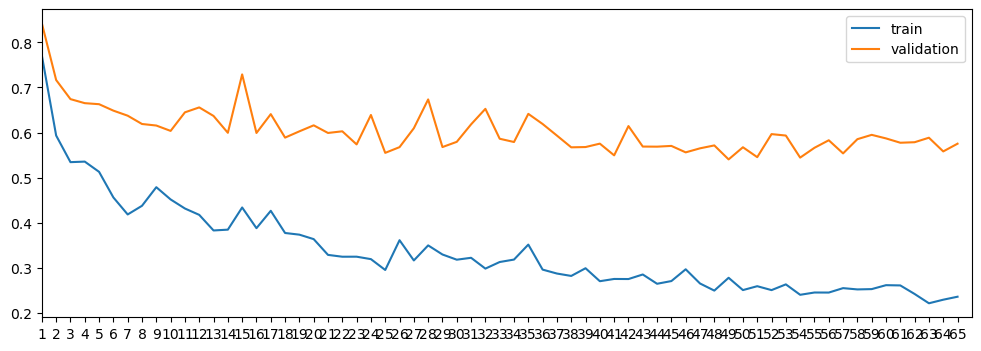

Epoch:65 Training Loss:0.2356114640252538 Validation Loss:0.5752011467734527: 100%|██████████| 65/65 [1:49:02<00:00, 100.66s/it] 


In [62]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"UCconjunto256.pt")


Hay underfitting

In [41]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("UCconjunto256.pt"))
mmodel.eval();

Dice coefficient tensor(0.4606)


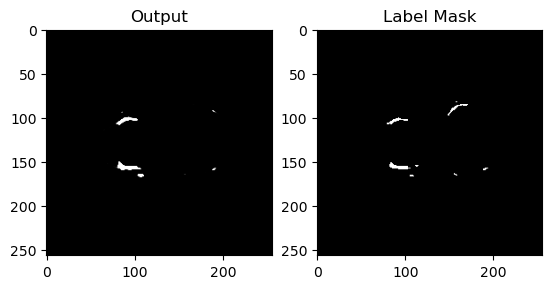

In [64]:
calculatediceCoeff(mmodel)
showsegmentation(test_dl, mmodel)

In [42]:
test_dl= DataLoader(val_data, batch_size=220)
calculatediceCoeff(mmodel)

Dice coefficient tensor(0.4593)


# Slices

Las imágenes proporcionadas por el dataset se encuentran en 3D, las de Singapur y Utrect contienen el mismo número de filtros. Por ello, podremos conseguir como máximo 48 imágenes: (Tutorial para crear gif:[enlace](https://www.codedex.io/projects/create-a-gif-with-python))

In [132]:
import imageio.v3 as iio
def makeagif(image,n_slices:int, name:str, bright:float):
    images=[]
    slices = image.shape[2] // n_slices
    if(image.shape[2] % n_slices !=0): slices+=1
    for ii in range(n_slices-1,-1,-1):
        im = image_data[:, :, ii * slices]
        im_adjusted = np.clip(im * bright, 0, 255).astype(np.uint8)
        images.append(im_adjusted)
    iio.imwrite(name, images, duration = 100, loop = 0)

In [133]:
flair= os.path.join(TRAINING_PATH_UTRECHT, "39","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata() 
makeagif(image_data,48,"flair.gif",0.15)

mask= os.path.join(TRAINING_PATH_UTRECHT, "39", "wmh.nii.gz")
img = nib.load(mask)
image_data = img.get_fdata() 
merged_image= np.array(image_data)
merged_image[merged_image==1]=255
merged_image[merged_image==2]=0
merged_image[merged_image==3]=255
image_data= merged_image
makeagif(image_data,48,"mask.gif",1.0)

t1= os.path.join(TRAINING_PATH_UTRECHT, "39","pre","T1.nii.gz")
img = nib.load(t1)
image_data = img.get_fdata() 
makeagif(image_data,48,"t1.gif",0.15)


<div style="display:flex; justify-content: space-around;"">
    <img src="imagenInformes/flair.gif" alt="GIF 1" style="width:33%;">
    <img src="imagenInformes/mask.gif" alt="GIF 2" style="width:33%;">
    <img src="imagenInformes/t1.gif" alt="GIF 3" style="width:33%;">
</div>

Vamos a observar las de Amsterdam. En el dataset de entrenamiento posee 83 filtros mientras que en el de test hay imágenes que poseen 83 y otras 103:

In [134]:
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","FLAIR.nii.gz")
img = nib.load(flair)
image_data = img.get_fdata()
makeagif(image_data,83,"flairAMS.gif",0.15)

t1= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nib.load(t1)
image_data = img.get_fdata() 
makeagif(image_data,83,"t1AMS.gif",0.15)

mask= os.path.join(TRAINING_PATH_AMSTERDAM, "100","wmh.nii.gz")
img = nib.load(mask)
image_data = img.get_fdata() 
merged_image= np.array(image_data)
merged_image[merged_image==1]=255
merged_image[merged_image==2]=0
merged_image[merged_image==3]=255
image_data= merged_image
makeagif(image_data,83,"maskAMS.gif",1.0)

(132, 256, 83)
(132, 256, 83)


<div style="display:flex; justify-content: space-around;">
    <img src="imagenInformes/flairAMS.gif" alt="GIF 1" style="width:33%;">
    <img src="imagenInformes/maskAMS.gif" alt="GIF 2" style="width:33%;">
    <img src="imagenInformes/t1AMS.gif" alt="GIF 3" style="width:33%;">
</div>

Como podemos observar algunos slices del principio que contienen el rostro y el final que contienen la base del cráneo no son necesarios ya que no contienen manchas. En el método ganador estos slices son eliminados por su poca utilidad. 

Por tanto debemos crear una nueva clase Dataset para que podamos seleccionar los slices que queramos:

# Librería

In [23]:
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("Flair256iter35.pt"))
mmodel.eval();

FileNotFoundError: [Errno 2] No such file or directory: 'Flair256iter35.pt'

In [21]:
from uib_vfeatures.masks import Masks
from uib_vfeatures import Features_mask as ftrs
import cv2

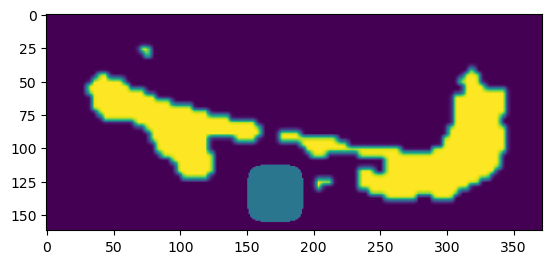

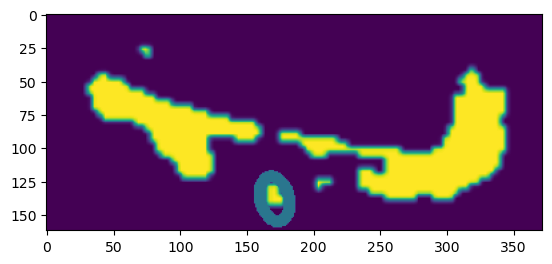

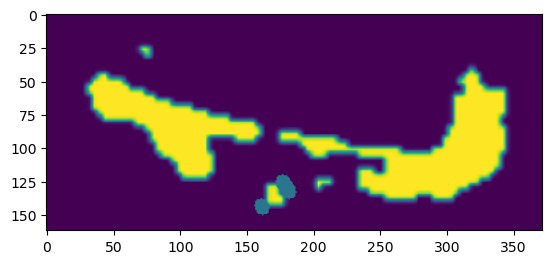

15.742063391025754

In [37]:
mask= os.path.join(TEST_PATH_UTRECHT, "9", "wmh.nii.gz")
img = nib.load(mask)
image_data = img.get_fdata() 
merged_image= np.array(image_data)
merged_image[merged_image==1]=255
merged_image[merged_image==2]=0
merged_image[merged_image==3]=255
image_data= merged_image

#image_data[:, :, image_data.shape[2] // 2]

mask = cv2.imread("./prueba.png")
image = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
Masks.bounding_box_area(image, True)

Masks.eccentricity(image, True)
Masks.solidity(image, True)

Masks.area(image)
Masks.shape(image)